In [1]:
import json
import os

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor 

## Load Data

In [2]:
# Set Seaborn theme
sns.set_style('whitegrid')

# Location for the local data
path = './transit_vis/data/delay_modeling_datasets'

# Read urban variable shapefiles
street_data = pd.read_csv(f"{path}/Seattle_Streets.csv", low_memory=False)
bike_data = pd.read_csv(f"{path}/Existing_Bike_Facilities.csv", low_memory=False)
flow_data = pd.read_csv(f"{path}/2018_Traffic_Flow_Counts.csv", low_memory=False)
blockface_data = pd.read_csv(f"{path}/Blockface.csv", low_memory=False)

# Read data from summarize_rds
bus_data_all = pd.read_csv(f"{path}/../all_data.csv", chunksize=1000000, low_memory=False)
bus_data_df = pd.concat(bus_data_all)
del bus_data_all

# Read sharedstreets data
ss_data = pd.read_csv(f"{path}/ss_joined.csv", low_memory=False)

# Filter datasets to variables of interest
street_data = street_data[['COMPKEY','ARTDESCRIPT','SPEEDLIMIT','ONEWAY','SEGLENGTH','SURFACEWIDTH','STREETTYPE',
                           'TRANDESCRIPT','SLOPE_PCT']].copy()
bike_data = bike_data[['COMPKEY','EXISTING_FACILITY_TYPE']].copy()
flow_data = flow_data[['COMPKEY','DOWNTOWN','AWDT']].copy()
blockface_data = blockface_data[['SEGKEY','LOAD','ZONE']].copy().groupby('SEGKEY').sum().reset_index()
ss_data = ss_data[['periodAverageCount','type','join_COMPKEY','distance']]

In [3]:
# AWDT data has multiple compkeys per line comma separated
flow_data = flow_data.dropna()
ck = []
downtown = []
awdt = []
for i in range(0,len(flow_data)):
    keys = flow_data.iloc[i,0].split(',')
    for key in keys:
        ck.append(int(key))
        downtown.append(flow_data.iloc[i,1])
        awdt.append(flow_data.iloc[i,2])
flow_data = pd.DataFrame([ck,downtown,awdt])
flow_data = flow_data.transpose()
flow_data.columns = ['COMPKEY','DOWNTOWN','AWDT']

# AWDT also is recorded as strings
flow_data['AWDT'] = pd.to_numeric(flow_data['AWDT'], errors='coerce')
flow_data['COMPKEY'] = pd.to_numeric(flow_data['COMPKEY'], errors='coerce')
flow_data['COMPKEY'] = flow_data['COMPKEY'].astype('int')
flow_data['AWDT'] = flow_data['AWDT'].astype('int')

# For some reason there is a 'B' value for downtown - meaning not documented in metadata
flow_data = flow_data[flow_data['DOWNTOWN']!='B'].copy()

In [4]:
# Bus data needs to be aggregated by compkey and median/95th pct calculated for each segment
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'pct_%s' % n
    return percentile_

bus_data = bus_data_df.groupby(['seg_compkey']).agg(['median', 'var', 'count', percentile(95)]).reset_index()
bus_data = bus_data.loc[bus_data[('seg_route_id', 'count')] > 1]
x = bus_data[('seg_compkey')].values
y = bus_data[('avg_speed_m_s')][['median','pct_95']].iloc[:,0].values
z = bus_data[('avg_speed_m_s')][['median','pct_95']].iloc[:,1].values
bus_data = pd.DataFrame([x,y,z]).transpose()
bus_data.columns = ['seg_compkey','median','pct_95']
bus_data['performance'] = bus_data['median'] / bus_data['pct_95']

In [5]:
# Sharedstreets data needs to be aggregated by compkey and pickups/dropoffs added together/averaged
pickups = ss_data[ss_data['type']=='pickup'].groupby(['join_COMPKEY']).sum()
dropoffs = ss_data[ss_data['type']=='dropoff'].groupby(['join_COMPKEY']).sum()
ss_data = pd.merge(pickups, dropoffs, on='join_COMPKEY')
ss_data['total_hourly_PUDO'] = ss_data['periodAverageCount_x'] + ss_data['periodAverageCount_y']
ss_data = ss_data[['total_hourly_PUDO']].reset_index()

In [6]:
# Print length (# of compkeys) in each dataset to get idea of how many streets have full data
print(len(street_data))
print(len(bike_data))
print(len(flow_data))
print(len(blockface_data))
print(len(bus_data))
print(len(ss_data))

23806
3372
6078
23839
3908
8450


In [7]:
# Merge all datasets on Compkey
model_data = pd.merge(street_data, bike_data.dropna(), how='left', on='COMPKEY')
model_data = pd.merge(model_data, flow_data, how='left', on='COMPKEY')
model_data = pd.merge(model_data, blockface_data, how='left', left_on='COMPKEY', right_on='SEGKEY')
model_data = pd.merge(model_data, bus_data, how='left', left_on='COMPKEY', right_on='seg_compkey')

# Add case where there is no bike facility
model_data.loc[pd.isna(model_data['EXISTING_FACILITY_TYPE']), 'EXISTING_FACILITY_TYPE'] = 'No_Facility'

# Create separate dataset that includes the sharedstreets data
model_data_w_ss = pd.merge(model_data, ss_data, how='left', sort=True, left_on='COMPKEY', right_on='join_COMPKEY')
model_data_w_ss = model_data_w_ss.dropna()

In [8]:
# Show how many NA values per column (places where data not available)
# Note: AWDT is not available for many streets, and bus data is only available for streets in the bus network
# There should be about 4000 streets in the bus network
# About 200 streets are lost due to incomplete AWDT data
# About 1600 streets are lost due to incomplete SS data
print(model_data.isnull().sum(axis=0))

# Remove na rows
print()
print(len(model_data))
model_data = model_data.dropna()
print(len(model_data))

COMPKEY                       0
ARTDESCRIPT                   6
SPEEDLIMIT                    6
ONEWAY                       10
SEGLENGTH                     6
SURFACEWIDTH                  8
STREETTYPE                  790
TRANDESCRIPT                188
SLOPE_PCT                    18
EXISTING_FACILITY_TYPE        0
DOWNTOWN                  17729
AWDT                      17729
SEGKEY                        7
LOAD                          7
ZONE                          7
seg_compkey               19899
median                    19899
pct_95                    19899
performance               19899
dtype: int64

23813
3136


In [9]:
model_data

,COMPKEY,ARTDESCRIPT,SPEEDLIMIT,ONEWAY,SEGLENGTH,SURFACEWIDTH,STREETTYPE,TRANDESCRIPT,SLOPE_PCT,EXISTING_FACILITY_TYPE,DOWNTOWN,AWDT,SEGKEY,LOAD,ZONE,seg_compkey,median,pct_95,performance
22,1299,Minor Arterial,25.0,N,417.0,42.0,Urban Center Connector,MAJOR TRANSIT ROUTE,6.0,"In Street, Minor Separation",N,18147.0,1299.0,0.0,2.0,1299.0,8.0,18.00,0.444444
26,1364,Collector Arterial,25.0,N,150.0,30.0,Neighborhood Corridor,MINOR TRANSIT ROUTE,3.0,No_Facility,N,2000.0,1364.0,0.0,0.0,1364.0,6.0,9.00,0.666667
30,1407,Principal Arterial,25.0,Y,540.0,39.0,Urban Village Main,MAJOR TRANSIT ROUTE,5.0,"In Street, Minor Separation",N,10000.0,1407.0,1.0,1.0,1407.0,4.0,14.00,0.285714
43,1591,Principal Arterial,25.0,Y,178.0,28.0,Urban Center Connector,NOT DESIGNATED,1.0,No_Facility,N,3982.0,1591.0,0.0,0.0,1591.0,7.0,15.50,0.451613
49,1659,Collector Arterial,25.0,N,566.0,42.0,Neighborhood Corridor,MINOR TRANSIT ROUTE,2.0,Sharrow,N,2383.0,1659.0,0.0,0.0,1659.0,6.0,14.00,0.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23800,2341,Minor Arterial,25.0,N,653.0,44.0,Neighborhood Corridor,MINOR TRANSIT ROUTE,4.0,Sharrow,N,5695.0,2341.0,0.0,0.0,2341.0,9.0,19.00,0.473684
23803,22301,Minor Arterial,25.0,N,236.0,42.0,Urban Village Neighborhood,MINOR TRANSIT ROUTE,6.0,No_Facility,N,6285.0,22301.0,0.0,0.0,22301.0,8.0,20.00,0.400000
23804,10896,Principal Arterial,30.0,N,198.0,58.0,Industrial Access,MINOR TRANSIT ROUTE,1.0,No_Facility,N,23000.0,10896.0,0.0,0.0,10896.0,6.0,17.05,0.351906
23807,21459,Collector Arterial,25.0,N,323.0,50.0,Urban Village Neighborhood,MINOR TRANSIT ROUTE,2.0,No_Facility,N,2398.0,21459.0,0.0,0.0,21459.0,0.0,6.00,0.000000


## Linear Regression

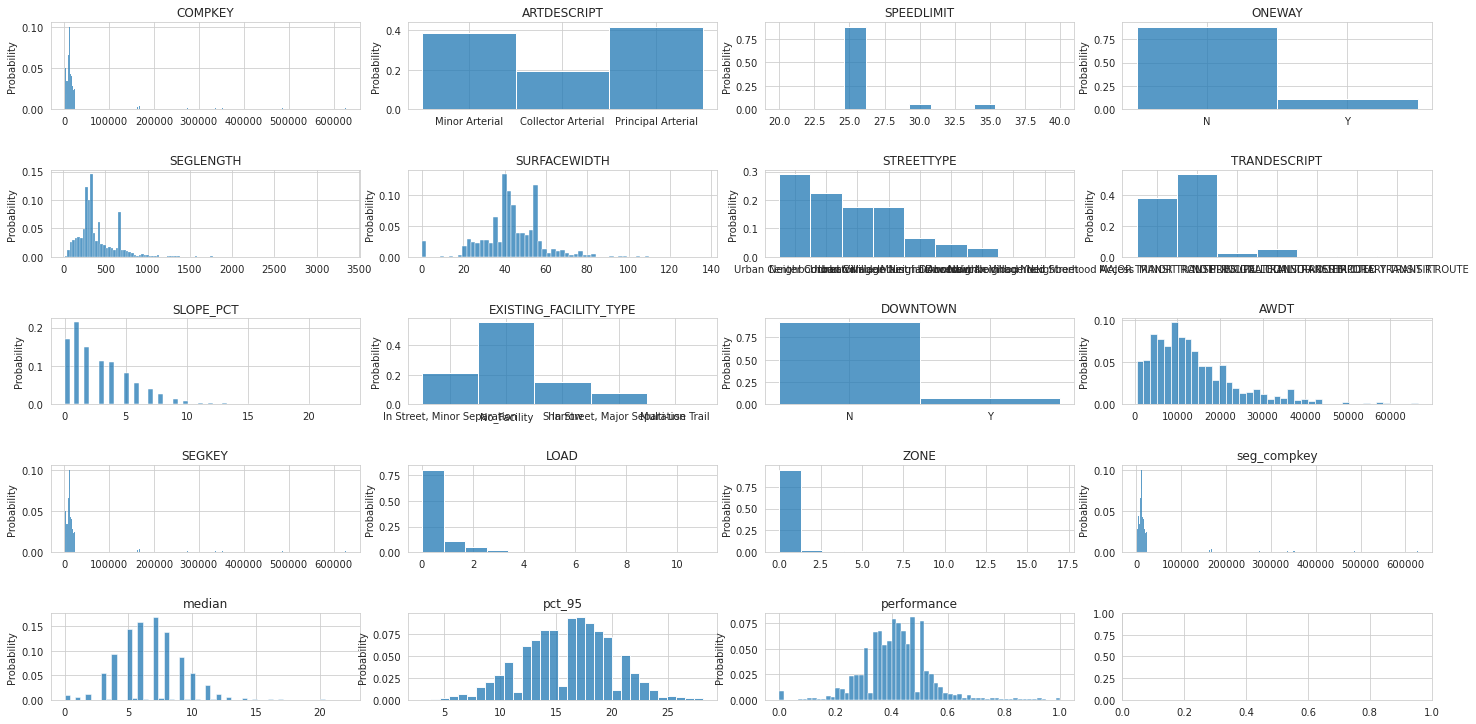

In [10]:
# Check for semi-normal distributions of all variables available in the model data df
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20,10))
fig.tight_layout(h_pad=4)

for i, col in enumerate(model_data.columns):
    sns.histplot(model_data[col], ax=axes.flat[i], stat='probability')
    axes.flat[i].set_title(col)
    axes.flat[i].set_xlabel(None)

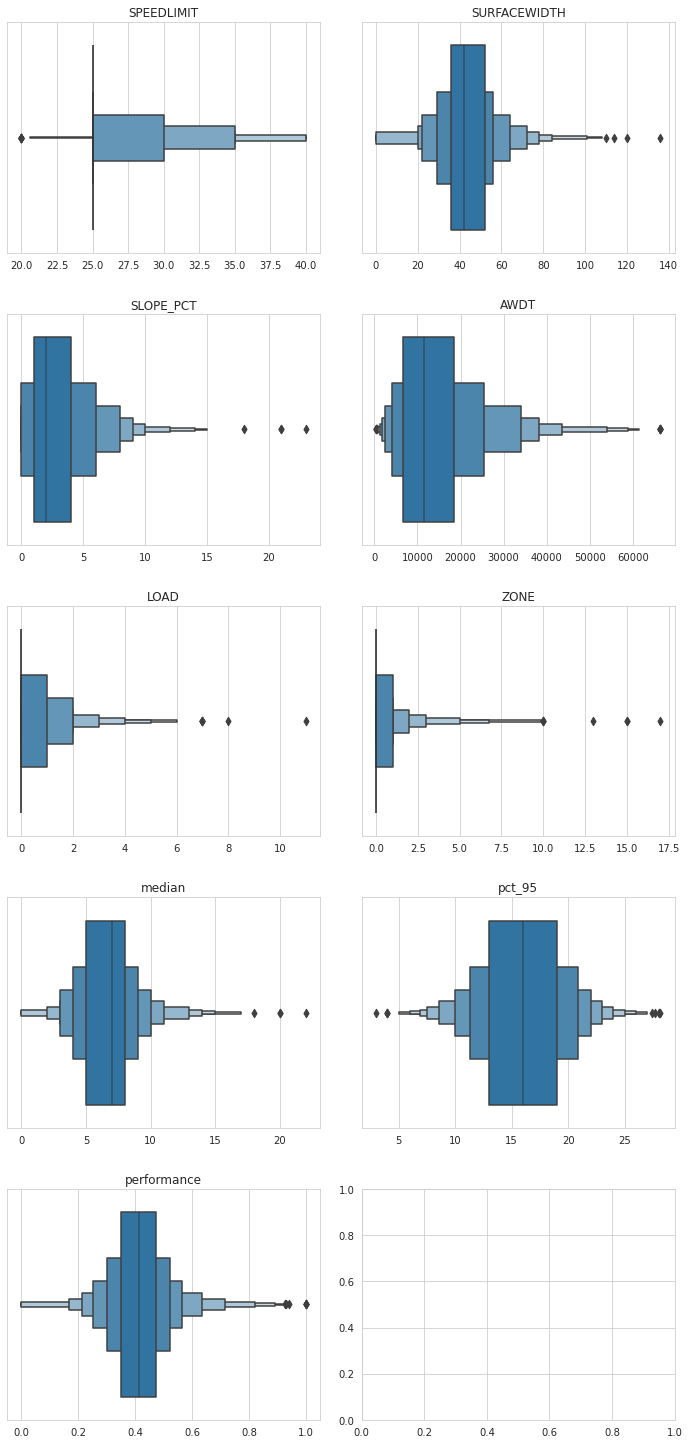

In [11]:
# Check the numerical variables for outliers
model_data_numeric = model_data[['SPEEDLIMIT','SURFACEWIDTH','SLOPE_PCT','AWDT','LOAD','ZONE','median','pct_95','performance']].copy()
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,20))
fig.tight_layout(h_pad=4)

for i, col in enumerate(model_data_numeric.columns):
    sns.boxenplot(x=model_data[col], ax=axes.flat[i])
    axes.flat[i].set_title(col)
    axes.flat[i].set_xlabel(None)

                      0
SPEEDLIMIT    71.357619
SURFACEWIDTH  10.380060
SLOPE_PCT      2.222556
AWDT           3.978305
LOAD           1.237316
ZONE           1.119263
median        85.632771
pct_95        94.967955
performance   59.232117


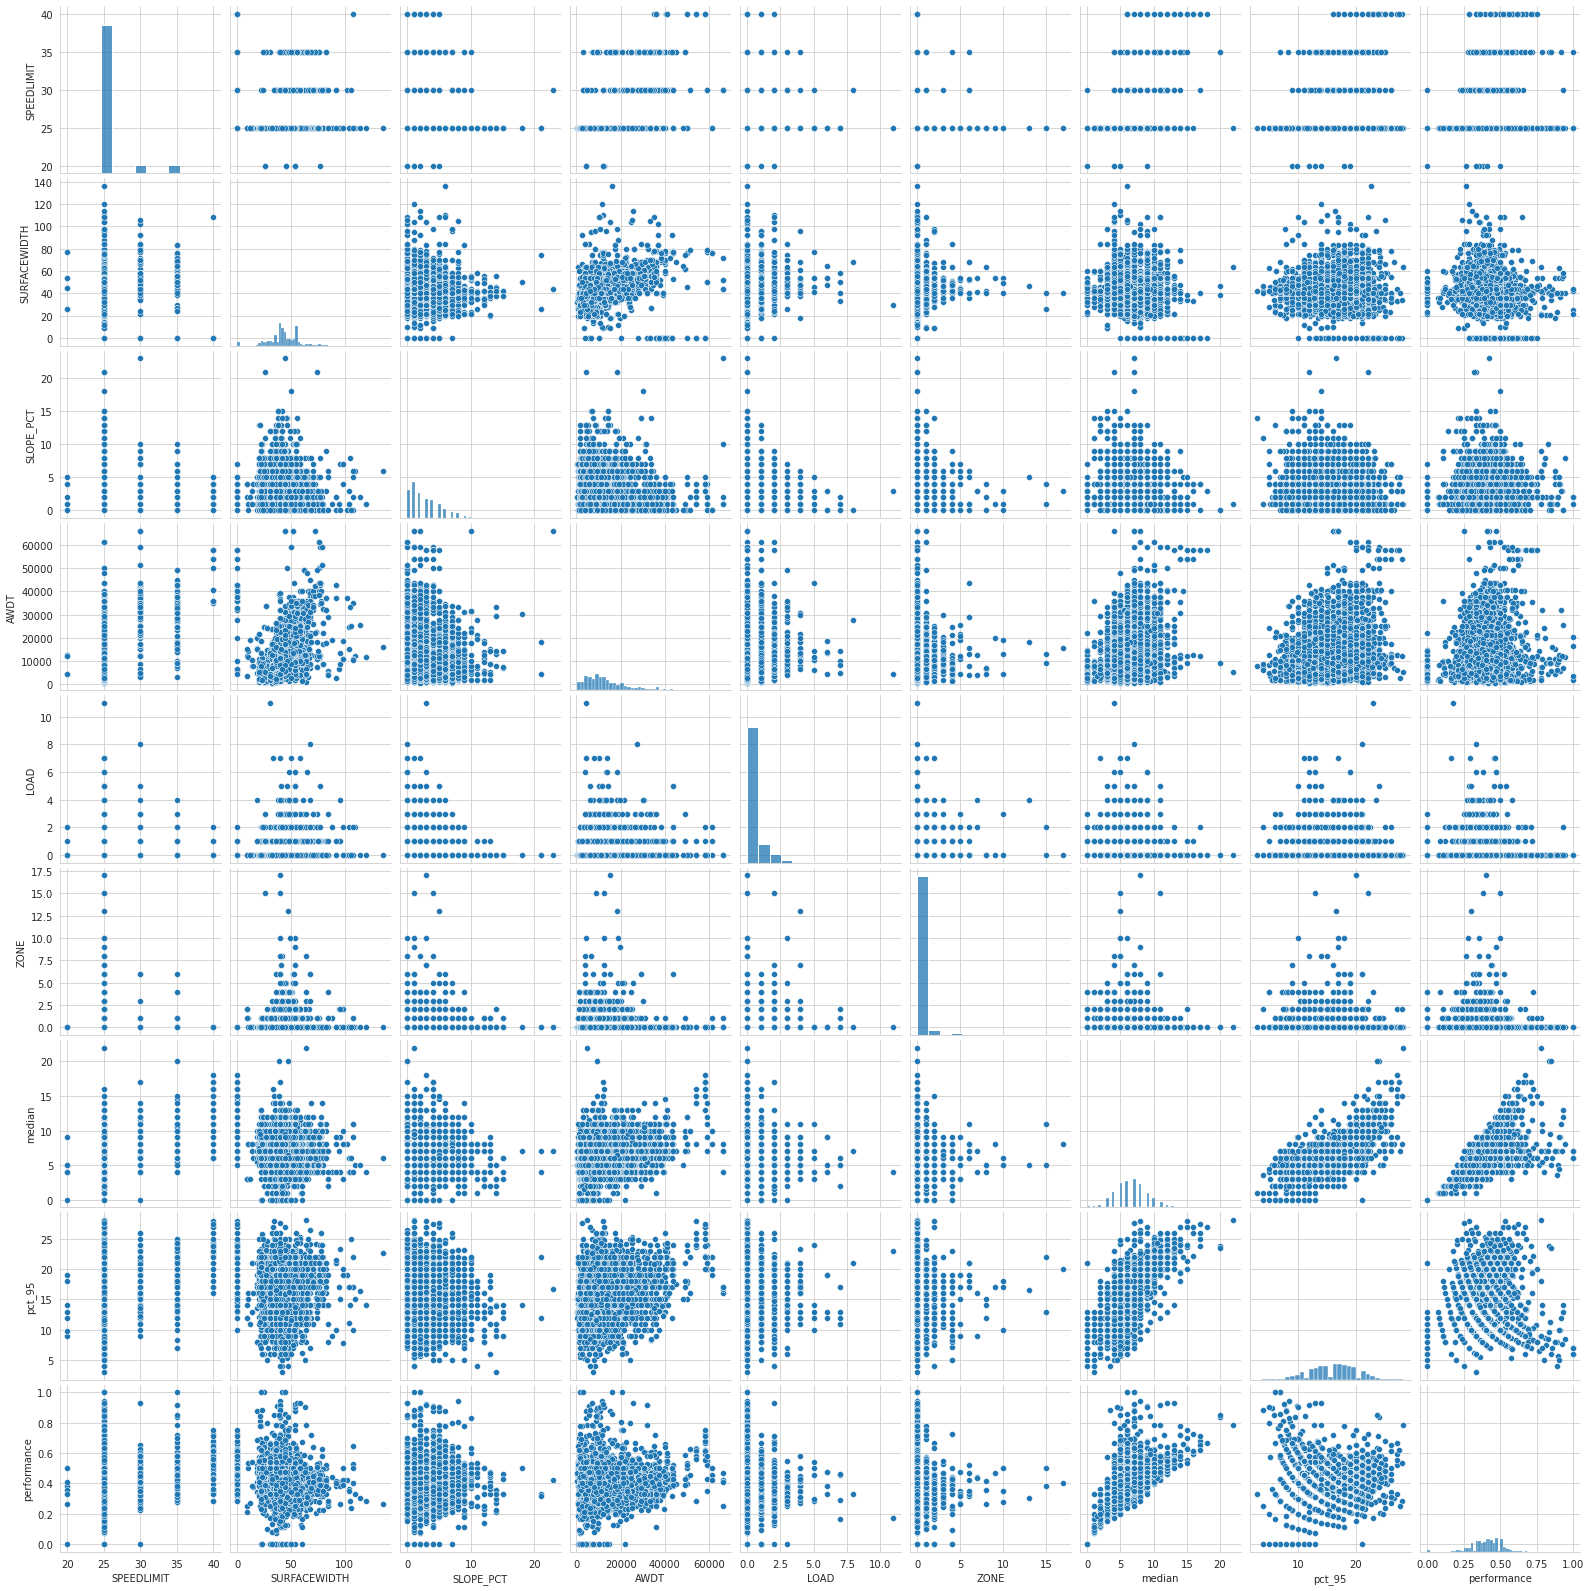

In [12]:
# Check the numerical variables for collinearity
sns.pairplot(model_data_numeric)

# Check the variance inflation factor (1/(1-R^2_i)) where all other variables are regressed against the i variable
# 1 = not correlated.
# Between 1 and 5 = moderately correlated.
# Greater than 5 = highly correlated.
vif_values = []
for i in range(len(model_data_numeric.columns)):
    vif = variance_inflation_factor(model_data_numeric.values, i)
    vif_values.append(vif)
print(pd.DataFrame(vif_values, model_data_numeric.columns))

In [13]:
# All variables
results = smf.ols('performance ~ \
                  C(ARTDESCRIPT, Treatment(reference="Minor Arterial")) + \
                  SPEEDLIMIT + \
                  C(ONEWAY, Treatment(reference="N")) + \
                  SEGLENGTH + \
                  SURFACEWIDTH + \
                  C(STREETTYPE, Treatment(reference="Neighborhood Corridor")) + \
                  C(TRANDESCRIPT, Treatment(reference="NOT DESIGNATED")) + \
                  SLOPE_PCT + \
                  C(EXISTING_FACILITY_TYPE, Treatment(reference="No_Facility")) + \
                  AWDT + \
                  LOAD + \
                  ZONE', data=model_data).fit()
print(results.summary())
print()
p = results.pvalues
print(p[p<.05])

                            OLS Regression Results                            
Dep. Variable:            performance   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     25.94
Date:                Mon, 01 Mar 2021   Prob (F-statistic):          4.02e-120
Time:                        17:11:40   Log-Likelihood:                 2653.6
No. Observations:                3136   AIC:                            -5249.
Df Residuals:                    3107   BIC:                            -5074.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

In [14]:
# Significant variables only
model_data_sig = model_data.copy()

# Consolidate categories of variables that had one or more significant classes
model_data_sig['TRANDESCRIPT'].replace(
                                to_replace=['MAJOR TRANSIT ROUTE','MINOR TRANSIT ROUTE','PRINCIPAL TRANSIT ROUTE','MINOR RESTRICTED TRANSIT RT','TEMPORARY TRANSIT ROUTE'],
                                value='NON-LOCAL TRANSIT ROUTE',
                                inplace=True)
model_data_sig['EXISTING_FACILITY_TYPE'].replace(
                                to_replace=['Sharrow','In Street, Major Separation','Multi-use Trail'],
                                value='Other Facility Type',
                                inplace=True)

results = smf.ols('performance ~ \
                  C(ARTDESCRIPT, Treatment(reference="Minor Arterial")) + \
                  SPEEDLIMIT + \
                  SURFACEWIDTH + \
                  C(STREETTYPE, Treatment(reference="Neighborhood Corridor")) + \
                  C(TRANDESCRIPT, Treatment(reference="NOT DESIGNATED")) + \
                  C(EXISTING_FACILITY_TYPE, Treatment(reference="No_Facility")) + \
                  AWDT + \
                  LOAD + \
                  ZONE', data=model_data_sig).fit()
print(results.summary())
print()
p = results.pvalues
print(p[p<.05])

                            OLS Regression Results                            
Dep. Variable:            performance   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     37.28
Date:                Mon, 01 Mar 2021   Prob (F-statistic):          1.84e-123
Time:                        17:11:40   Log-Likelihood:                 2645.3
No. Observations:                3136   AIC:                            -5251.
Df Residuals:                    3116   BIC:                            -5130.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

## Linear Model w/SharedStreets Data

<AxesSubplot:xlabel='total_hourly_PUDO', ylabel='Probability'>

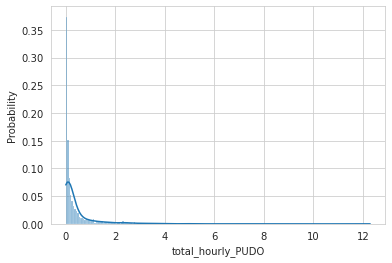

In [15]:
sns.histplot(model_data_w_ss['total_hourly_PUDO'], stat='probability', kde=True)

<AxesSubplot:xlabel='total_hourly_PUDO'>

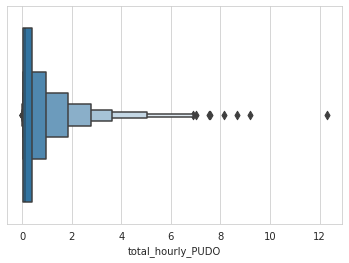

In [16]:
sns.boxenplot(x=model_data_w_ss['total_hourly_PUDO'])

                           0
total_hourly_PUDO   1.481856
SPEEDLIMIT         80.512487
SURFACEWIDTH       12.197428
SLOPE_PCT           2.242475
AWDT                4.254195
LOAD                1.390089
ZONE                1.238722
median             89.497482
pct_95             98.121617
performance        68.033587


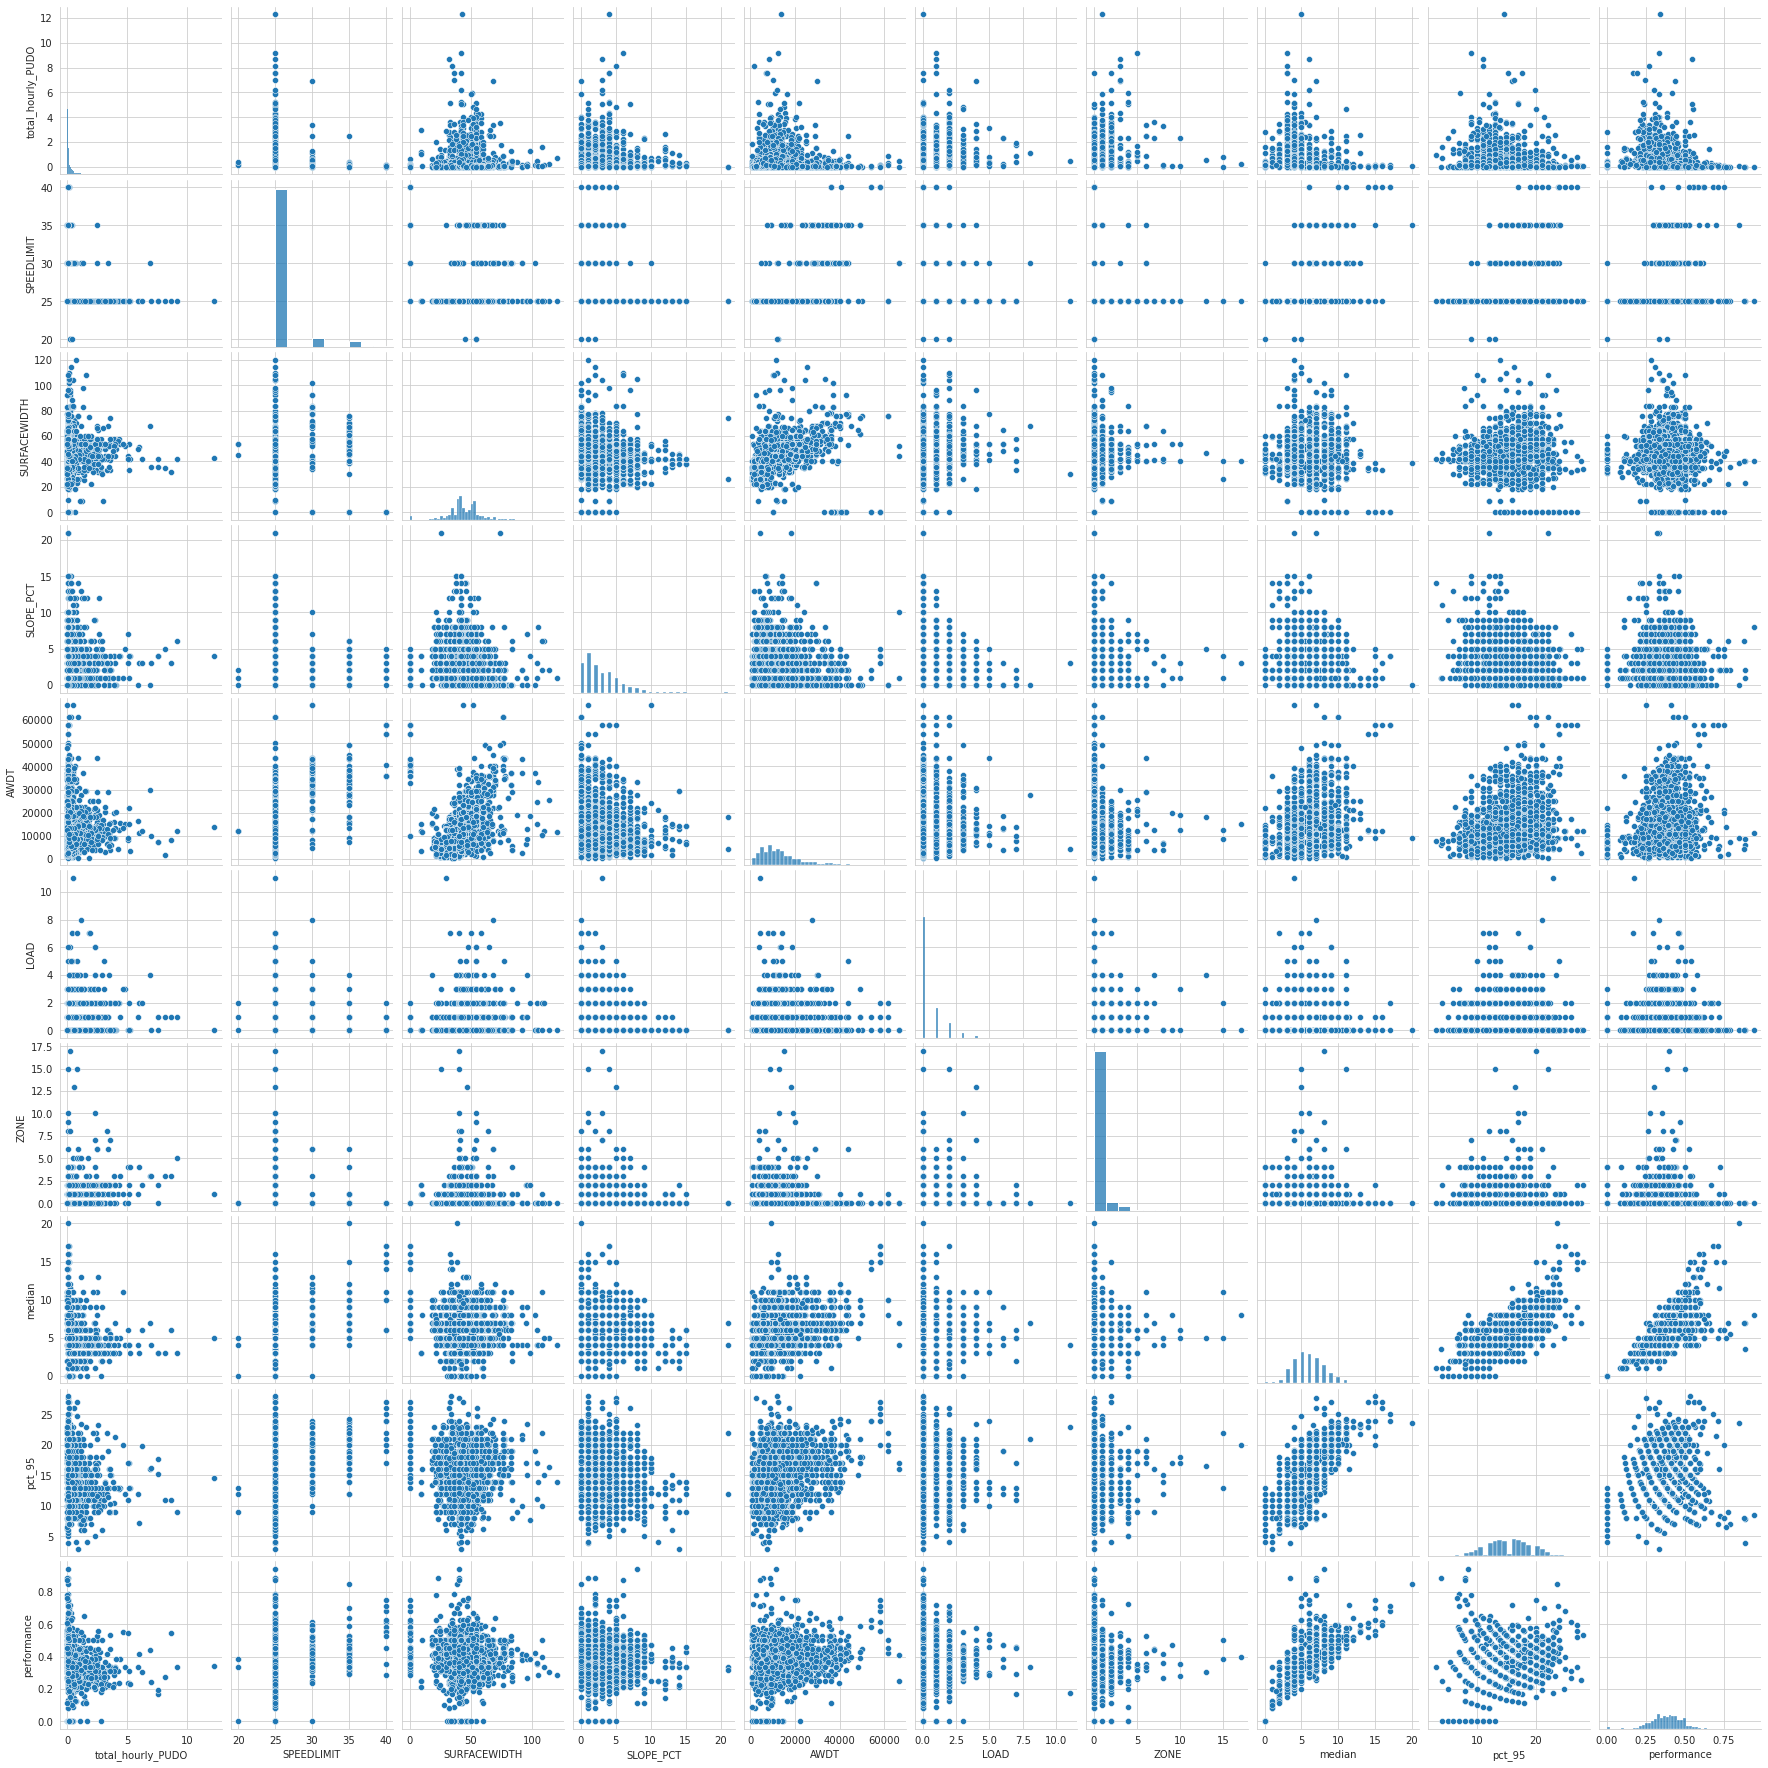

In [17]:
# Check the numerical variables for outliers
model_data_numeric_w_ss = model_data_w_ss[['total_hourly_PUDO','SPEEDLIMIT','SURFACEWIDTH','SLOPE_PCT','AWDT','LOAD','ZONE','median','pct_95','performance']].copy()

# Check the numerical variables for collinearity
sns.pairplot(model_data_numeric_w_ss)

# Check the variance inflation factor (1/(1-R^2_i)) where all other variables are regressed against the i variable
# 1 = not correlated.
# Between 1 and 5 = moderately correlated.
# Greater than 5 = highly correlated.
vif_values = []
for i in range(len(model_data_numeric_w_ss.columns)):
    vif = variance_inflation_factor(model_data_numeric_w_ss.values, i)
    vif_values.append(vif)
print(pd.DataFrame(vif_values, model_data_numeric_w_ss.columns))

In [18]:
# All variables
results = smf.ols('performance ~ \
                  C(ARTDESCRIPT, Treatment(reference="Minor Arterial")) + \
                  SPEEDLIMIT + \
                  C(ONEWAY, Treatment(reference="N")) + \
                  SEGLENGTH + \
                  SURFACEWIDTH + \
                  C(STREETTYPE, Treatment(reference="Neighborhood Corridor")) + \
                  C(TRANDESCRIPT, Treatment(reference="NOT DESIGNATED")) + \
                  SLOPE_PCT + \
                  C(EXISTING_FACILITY_TYPE, Treatment(reference="No_Facility")) + \
                  AWDT + \
                  LOAD + \
                  ZONE + \
                  total_hourly_PUDO', data=model_data_w_ss).fit()
print(results.summary())
print()
p = results.pvalues
print(p[p<.05])

                            OLS Regression Results                            
Dep. Variable:            performance   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     16.93
Date:                Mon, 01 Mar 2021   Prob (F-statistic):           4.03e-72
Time:                        17:11:56   Log-Likelihood:                 1672.9
No. Observations:                1801   AIC:                            -3288.
Df Residuals:                    1772   BIC:                            -3128.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                                                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

## Iterative Model Searches

In [19]:
# Try iteratively searching for optimal model
data_y = model_data_w_ss[['performance']].values
data_x = model_data_w_ss.drop(['COMPKEY','seg_compkey','join_COMPKEY','SEGKEY','median','pct_95','performance'], axis=1)
cat_vars = data_x.select_dtypes('object')
for col in cat_vars.columns:
    data_x[col] = data_x[col].factorize()[0]
data_x = data_x.values

In [20]:
def stepWiseFeatureSearch(x, y):
    predictor_idxs = []
    improved = True

    while improved:
        improved = False

        # Check which variable to add improves AIC the most
        best_to_add = -1
        best_to_add_aic = math.inf
        for i in range(x.shape[1]):
            if i in predictor_idxs:
                continue
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(x[:,predictor_idxs+[i]])))
            results = model.fit()
            if results.aic < best_to_add_aic:
                best_to_add = i
        if best_to_add >= 0:
            predictor_idxs.append(best_to_add)
            improved = True

        # Check if removing any variables improves AIC
        best_to_remove = -1
        best_to_remove_aic = math.inf
        for i in range(len(predictor_idxs)):
            predictor_idxs_new = predictor_idxs
            removed = predictor_idxs_new.pop(i)
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(x[:,predictor_idxs_new])))
            results = model.fit()
            if results.aic < best_to_remove_aic:
                best_to_remove = removed
        if best_to_remove >= 0:
            print(best_to_remove)
            predictor_idxs.remove(best_to_remove)
            improved = True
    
    return predictor_idxs

In [21]:
stepWiseFeatureSearch(data_x, data_y)

13


ValueError: list.remove(x): x not in list

In [2]:
path = './transit_vis/data/delay_modeling_datasets'

# Read data from summarize_rds
bus_data_all = pd.read_csv(f"{path}/../all_data.csv", chunksize=1000000, low_memory=False)
bus_data_df = pd.concat(bus_data_all)
del bus_data_all

In [16]:
bus_data_df = bus_data_df.iloc[0:100000,:]

In [27]:
bus_data_df['hour_of_day'] = pd.to_datetime(bus_data_df['locationtime'], unit='s').dt.tz_localize('UTC').dt.tz_convert(tz='America/Los_Angeles').dt.strftime('%-H').astype(int)

In [28]:
pd.unique(bus_data_df['hour_of_day'])

array([ 6,  7,  8,  9, 10, 11,  5])

In [39]:
time_periods = ['AM','PM','ALL']
times = [[6,9], [16,19], [0,23]] #6-9am, 4-7pm
for i, time_period in enumerate(times):
    filtered = bus_data_df[((bus_data_df['hour_of_day'] > time_period[0]) & (bus_data_df['hour_of_day'] < time_period[1]))]

0
       Unnamed: 0      tripid  vehicleid        lat         lon  orientation  \
5               5  34746101.0       7403  47.579708 -122.145096          358   
6               6  34746101.0       7403  47.581249 -122.141693          139   
7               7  34746101.0       7403  47.585384 -122.143723          189   
8               8  34746101.0       7403  47.585670 -122.148285           74   
9               9  34746101.0       7403  47.590202 -122.146202          121   
...           ...         ...        ...        ...         ...          ...   
99933       99933  49192229.0       4357  47.621895 -122.307327          268   
99934       99934  49192229.0       4357  47.619106 -122.307373          268   
99935       99935  49192229.0       4357  47.618015 -122.307388          269   
99936       99936  49192229.0       4357  47.616875 -122.307411          269   
99937       99937  49192229.0       4357  47.616398 -122.308212          202   

       scheduledeviation  prev_deviat